In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from decimal import Decimal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [3]:
df = pd.read_excel('ozone.xlsx')

### Introduction

These data record the level of atmospheric ozone concentration from eight daily meteorological measurements made in the Los Angeles basin in 1976.  

Although measurements were made every day that year, some observations were missing; here we have the 330 complete cases.  

The data were given to us by Leo Breiman; he was a consultant on a project from which these data are taken.  

The response, referred to as ozone, is actually the log of the daily maximum of the hourly-average ozone concentrations in Upland, California.

### Variables

ozone : Upland Maximum Ozone

vh : Vandenberg 500 mb Height

wind : Wind Speed (mph)

humidity : Humidity (%)

temp : Sandburg AFB Temperature

ibh : Inversion Base Height

dpg : Daggot Pressure Gradient

ibt : Inversion Base Temperature

vis : Visibility (miles)

doy : Day of the Year

In [4]:
samples, variables = df.shape
print(f'Number of samples: {samples}, number of variables: {variables}')

Number of samples: 330, number of variables: 10


In [5]:
print(f'Quick overview of the Dataframe content:')
df

Quick overview of the Dataframe content:


,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7
...,...,...,...,...,...,...,...,...,...,...
325,8,5630,4,50,50,2851,-5,100,70,359
326,2,5730,3,53,51,111,-14,225,200,362
327,3,5690,3,23,51,5000,-36,107,70,363
328,5,5650,3,61,50,3704,18,83,40,364


In [6]:
null_values = df.isnull().sum()

print(f"null values: {null_values}")

null values: ozone       0
vh          0
wind        0
humidity    0
temp        0
ibh         0
dpg         0
ibt         0
vis         0
doy         0
dtype: int64


### Data Exploration

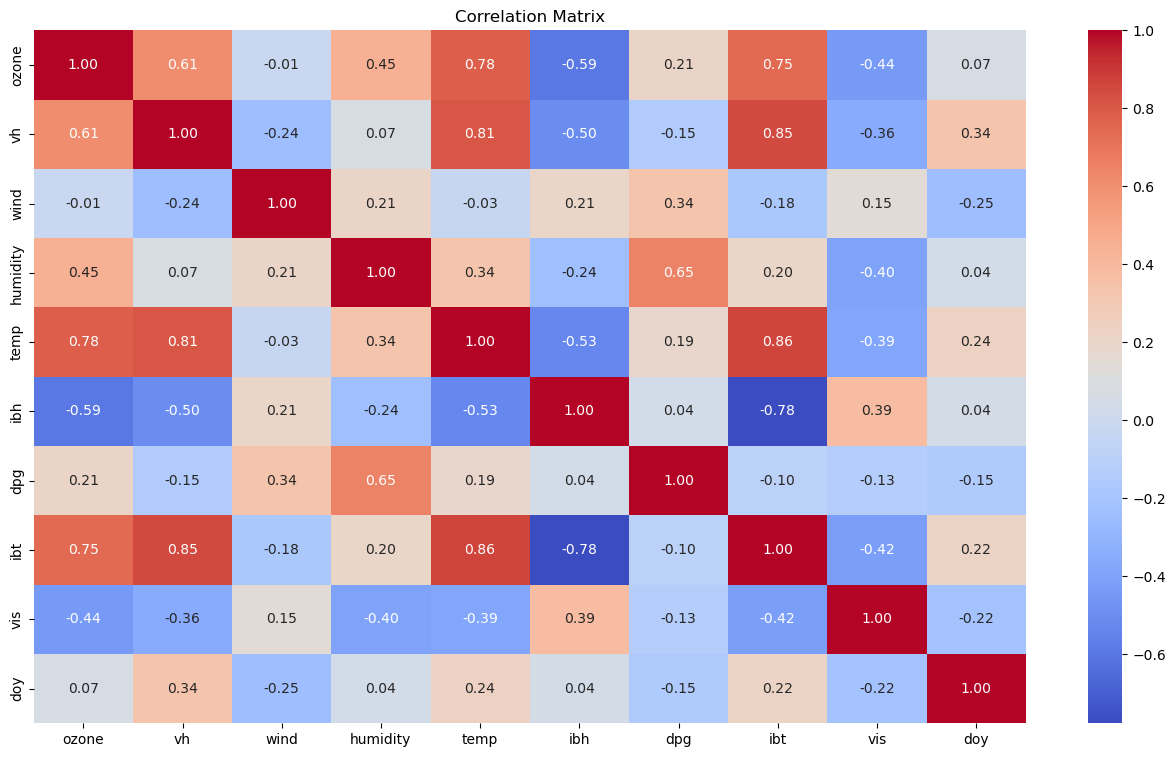

In [7]:
# Assuming you have a DataFrame named 'df'
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

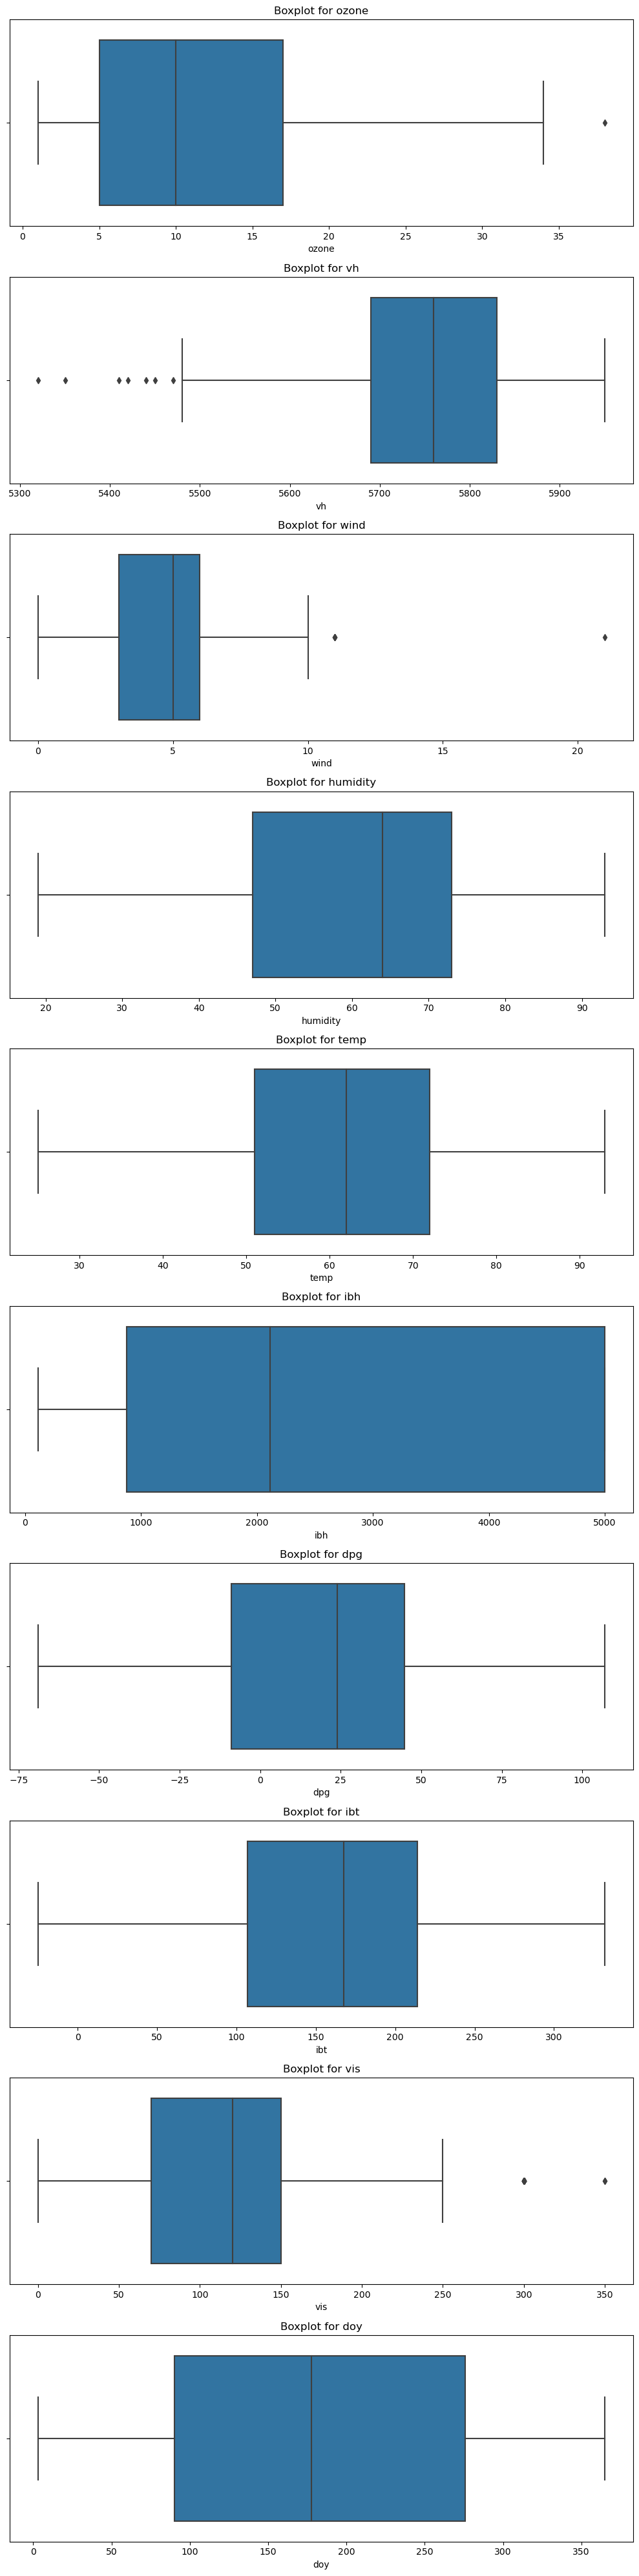

In [8]:
# Get the list of numerical columns in your dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 4 * len(numerical_columns)))

# Iterate over each numerical column and create a box plot
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

### Response exploration (ozone)

In [9]:
target_min, target_max = df["ozone"].min(), df["ozone"].max()

print(f"target variable domain: [ {target_min} ; {target_max} ]")

target variable domain: [ 1 ; 38 ]


In [10]:
target_mean = df["ozone"].mean()

print(f"target variable mean: {target_mean}")

target variable mean: 11.775757575757575


### Response and Regressors definition

In [11]:
y = df['ozone']
X = df.drop('ozone', axis = 1)

## LASSO Regression

In [370]:
# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Fit LASSO model
lasso = Lasso(alpha = 1.0)
lasso.fit(X_standardized, y)

# Coefficients obtained from LASSO
lasso_coefficients = lasso.coef_

y_pred = lasso.predict(X_standardized)

### Mean Squared Error

In [371]:
mse = mean_squared_error(y, y_pred)
print(f'Mean Square Error: {mse}')

Mean Square Error: 21.787642254667784


### LASSO Coefficients

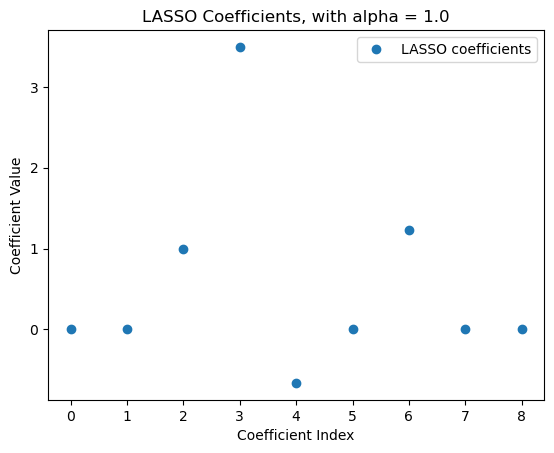

In [372]:
# Visualize the LASSO coefficients
plt.plot(lasso.coef_, marker='o', linestyle='None', label='LASSO coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title(f'LASSO Coefficients, with alpha = {alpha}')
plt.legend()
plt.show()

In [400]:
# Identify selected features (non-zero coefficients)
selected_feature_indices = np.where(lasso_coefficients != 0)[0]

# Map selected feature indices to column names
selected_features = X.columns[selected_feature_indices]

# Print selected features
print("Selected Features:", selected_features)

Selected Features: Index(['humidity', 'temp', 'ibh', 'ibt', 'vis'], dtype='object')


## Analysis of outliers, leverages and influential points

In [12]:
# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Display the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  ozone   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     83.40
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.65e-78
Time:                        22:05:12   Log-Likelihood:                -955.16
No. Observations:                 330   AIC:                             1930.
Df Residuals:                     320   BIC:                             1968.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3793     29.505      0.623      0.5

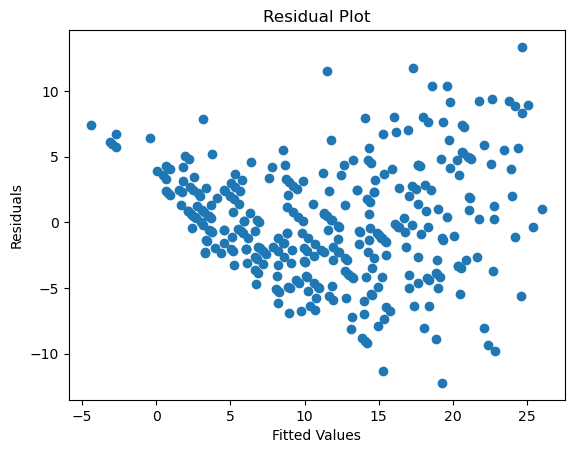

In [31]:
residuals = results.resid

# Plot residuals to identify outliers
plt.scatter(results.fittedvalues, residuals)
plt.title('Residual Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## Analysis of Cook's Distance

In [72]:
# Calculate Cook's Distance
influence = results.get_influence()
cooks_distance = influence.cooks_distance

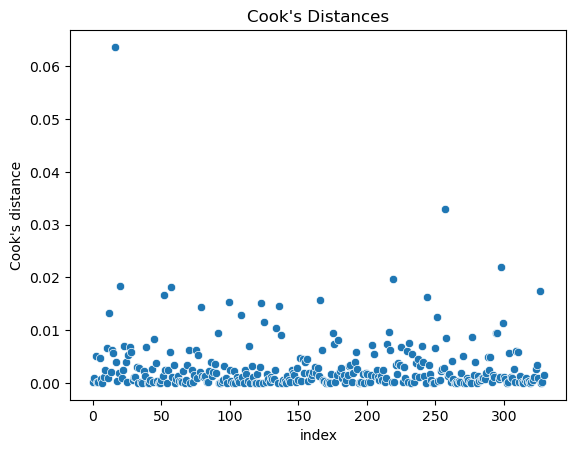

In [73]:
# Plot Cook's Distance
plt.xlabel('index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distances")
sns.scatterplot(data=cooks_distance[0])
plt.show()

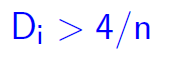

Where:

    - D_i is the i-th Cook's distance
    - n is the number of samples

The point is influential only if the condition is met

In [74]:
print(f"Cook's distance threshold: {(4/samples)}")
cook_influential_points = []

for i, D in enumerate(cooks_distance[0]):
    if D > (4/samples):
        print(f"Point {i} is influential according to Cook's distance, D-{i} value: {D}")
        cook_influential_points.append(i)

Cook's distance threshold: 0.012121212121212121
Point 12 is influential according to Cook's distance, D-12 value: 0.013338438448858007
Point 16 is influential according to Cook's distance, D-16 value: 0.06367130026997782
Point 20 is influential according to Cook's distance, D-20 value: 0.01839575195093211
Point 52 is influential according to Cook's distance, D-52 value: 0.016706529219613128
Point 57 is influential according to Cook's distance, D-57 value: 0.018254592845939683
Point 79 is influential according to Cook's distance, D-79 value: 0.014466734241740742
Point 99 is influential according to Cook's distance, D-99 value: 0.015350563778160364
Point 108 is influential according to Cook's distance, D-108 value: 0.012865431607644069
Point 123 is influential according to Cook's distance, D-123 value: 0.015136974863438539
Point 136 is influential according to Cook's distance, D-136 value: 0.01450366998080539
Point 166 is influential according to Cook's distance, D-166 value: 0.015788580

In [75]:
cook_influential_points

[12, 16, 20, 52, 57, 79, 99, 108, 123, 136, 166, 219, 244, 251, 257, 298, 326]

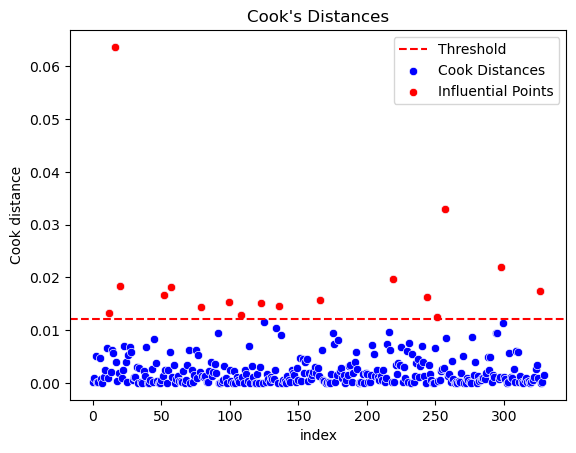

In [76]:
threshold = (4/samples)
influential_points_arr = np.array(cook_influential_points)
cook_distances_arr = np.array(cooks_distance[0])

plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

sns.scatterplot(x=np.arange(len(cook_distances_arr)), y=cook_distances_arr, color='blue', label='Cook Distances')

sns.scatterplot(x=influential_points_arr, y=cook_distances_arr[influential_points_arr], color='red', label='Influential Points')

plt.title("Cook's Distances")
plt.xlabel('index')
plt.ylabel('Cook distance')
plt.legend()
plt.show()

## Analysis of Leverages Points

In [77]:
# Calculate leverage
leverage = influence.hat_matrix_diag

### Plot of leverages points (hat-values)

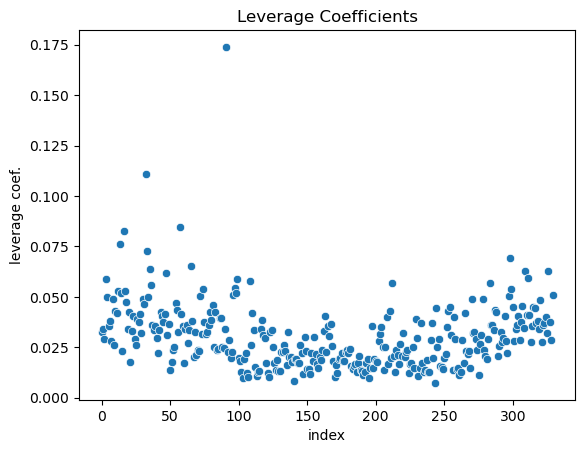

In [78]:
plt.xlabel('index')
plt.ylabel('leverage coef.')
plt.title('Leverage Coefficients')
sns.scatterplot(data = leverage)
plt.show()

### High Leverage Points Identification

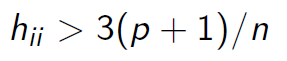

Where:

    - h_ii is the i-th hat value
    - p is the number of variables
    - n is the number of samples

In [79]:
# h_ii > ( 3 * ( p + 1 ) ) / n
# where variables = p, and samples = n
threshold = Decimal( ( 3 * ( variables + 1 ) ) / samples) 
print(f'Leverage threshold value: {threshold}')
high_leverage_points = []

for i, h in enumerate(leverage):    
    if h > threshold:
        print(f'Point-{i} of leverage, value: {h}')
        high_leverage_points.append(i)

Leverage threshold value: 0.1000000000000000055511151231257827021181583404541015625
Point-32 of leverage, value: 0.11079307067568617
Point-91 of leverage, value: 0.17392868060921696


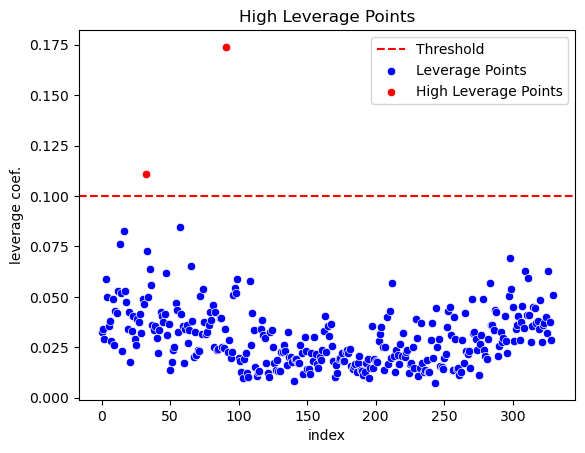

In [80]:
# Create a horizontal line at the threshold
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
leverage_arr = np.array(leverage)
high_leverage_points_arr = np.array(high_leverage_points)

# Scatter plot with high leverage points in red
sns.scatterplot(x=np.arange(len(leverage)), y=leverage, color='blue', label='Leverage Points')

# Highlight high leverage points above the threshold
sns.scatterplot(x=high_leverage_points, y=leverage[high_leverage_points], color='red', label='High Leverage Points')

plt.title('High Leverage Points')
plt.xlabel('index')
plt.ylabel('leverage coef.')
plt.legend()
plt.show()

## Analysis of Difference in Fits (DFFITS)

In [81]:
# Get studentized residuals and leverage
student_resid = influence.resid_studentized_internal

# Calculate DFFITS
nobs = len(results.fittedvalues)
dffits = student_resid * np.sqrt(leverage / (1 - leverage))

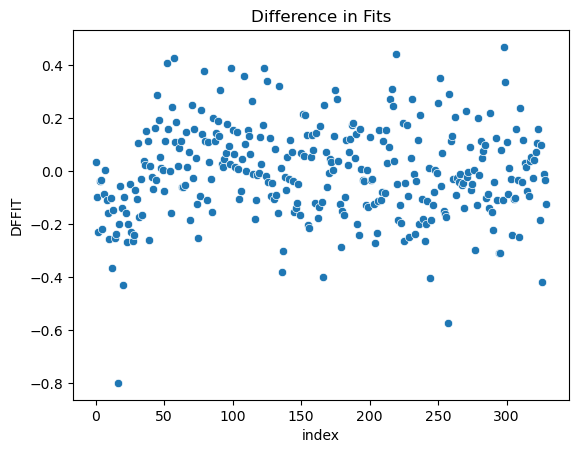

In [82]:
plt.xlabel('index')
plt.ylabel("DFFIT")
plt.title("Difference in Fits")
sns.scatterplot(data=dffits)
plt.show()

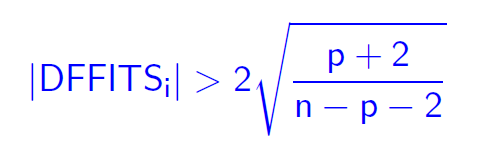

Where

    - DFFITS_i is the i-th Difference in Fit
    - p is the number of variables
    - n is the number of samples

In [85]:
threshold = 2 * math.sqrt( (variables + 2) / (samples - variables - 2) )
print(f'Distance in Fits threshold: {threshold}')
influential_points = []

for i, dffit in enumerate(dffits):    
    if abs(dffit) > threshold:
        print(f'Point-{i}, DFFIT: {dffit}')
        influential_points.append(i)

Distance in Fits threshold: 0.38851434494290565
Point-16, DFFIT: -0.7979429821107384
Point-20, DFFIT: -0.4289026923549456
Point-52, DFFIT: 0.4087362134630736
Point-57, DFFIT: 0.42725393908002396
Point-99, DFFIT: 0.39179795530554223
Point-123, DFFIT: 0.3890626538674528
Point-166, DFFIT: -0.3973484696603467
Point-219, DFFIT: 0.4436979557689674
Point-244, DFFIT: -0.40394452753072335
Point-257, DFFIT: -0.5735510995126484
Point-298, DFFIT: 0.4695087039394541
Point-326, DFFIT: -0.4184117558431601


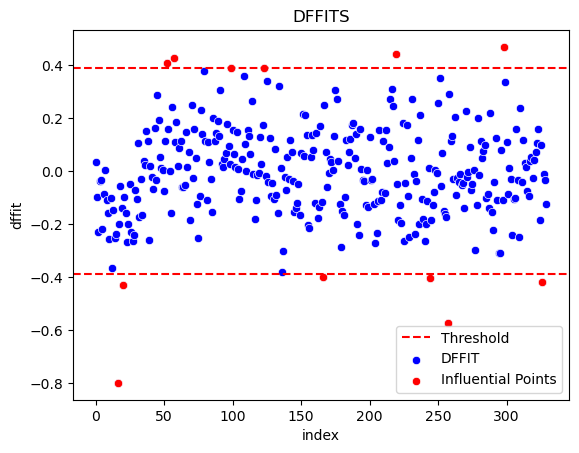

In [84]:
influential_points_arr = np.array(influential_points)
dffits = np.array(dffits)

# Plot thresholds
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='red', linestyle='--')

# Plot dffit
sns.scatterplot(x=np.arange(len(dffits)), y=dffits, color='blue', label='DFFIT')

# Plot influential points
sns.scatterplot(x=influential_points_arr, y=dffits[influential_points_arr], color='red', label='Influential Points')

plt.title("DFFITS")
plt.xlabel('index')
plt.ylabel('dffit')
plt.legend()
plt.show()

### References

Dataset provided by: https://hastie.su.domains/ElemStatLearn/

Lasso model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

OLS: https://www.statsmodels.org/stable/index.html